# Forecasting Bus Demand

The central urban planning commitee of Banana Republic asked you to help them with the forecast of bus demands of municipalities. And they provide a nice dataset to support you (https://pi.works/3w8IJbV).

![Bus](https://static.timesofisrael.com/www/uploads/2022/06/F150424NS130-640x400.jpg)

The dataset includes two measurements for an hour for the number of used buses in each municipality, each measurement is timestamped. The dataset format is as follows (comma separated values):
MUNICIPALITY_ID, TIMESTAMP, USAGE, TOTAL_CAPACITY
where municipality_id is an anonymization to disguise the actual names, timestamp represents the exact time of the measurement, usage is the number of buses in use at the time of measurement and total_capacity represents the total number of buses in the municipality. There are 10 municipalities (ids from 0 to 9), and two measurements for an hour.
The committee asks you to forecast the hourly bus usages for next week for each municipality. Hence you can aggregate the two measurements for an hour by taking the max value (sum would not be a nice idea for the obvious reasons) for each hour, and you should model this data with a time series model of your selection. (It would be a nice idea to implement a very simple baseline model first, and then try to improve the accuracy by introducing more complex methods eventually. The bare minimum requirement of the task is one simple baseline and one complex method.)


The committee says that they will use the last two weeks (starting from 2017-08-05 to 2017-08-19) as assessment (test) data, hence your code should report the error (in the criterion you chose for the task) for the last two weeks. You may use true values for the prediction of the last week of test data, then combine the error of the first and last week of the test separately.


Keep in mind that the dataset has missing data, hence a suitable missing data interpolation would be useful.

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import optuna
from hyperopt import tpe, hp, fmin, Trials
import itertools

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("/kaggle/input/minicipality-bus-utilization/municipality_bus_utilization.csv")

In [3]:
def check_df(dataframe):
    print(" SHAPE ".center(70, "~"))
    print(dataframe.shape)
    print(" TYPES ".center(70, "~"))
    print(dataframe.dtypes)
    print(" HEAD ".center(70, "~"))
    display(dataframe.head())
    print(" TAIL ".center(70, "~"))
    display(dataframe.tail())
    print(" INFO ".center(70, "~"))
    print(dataframe.info())
    print(" NA ".center(70, "~"))
    print(dataframe.isnull().sum())
    print(" DESCRIBE ".center(70, "~"))
    display(dataframe.describe().T)
    print(" QUANTILES ".center(70, "~"))
    display(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99]).T)

check_df(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SHAPE ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
(13070, 4)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ TYPES ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
timestamp          object
municipality_id     int64
usage               int64
total_capacity      int64
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ HEAD ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ TAIL ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,timestamp,municipality_id,usage,total_capacity
13065,2017-08-19 16:30:35,2,548,697
13066,2017-08-19 16:30:35,8,1193,2947
13067,2017-08-19 16:30:35,7,1354,2019
13068,2017-08-19 16:30:35,6,1680,3113
13069,2017-08-19 16:30:35,3,1189,1930


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ INFO ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13070 entries, 0 to 13069
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   timestamp        13070 non-null  object
 1   municipality_id  13070 non-null  int64 
 2   usage            13070 non-null  int64 
 3   total_capacity   13070 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 408.6+ KB
None
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ NA ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
timestamp          0
municipality_id    0
usage              0
total_capacity     0
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ DESCRIBE ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,count,mean,std,min,25%,50%,75%,max
municipality_id,13070.0,4.500000,2.872391,0.0,2.0,4.5,7.0,9.0
usage,13070.0,876.002984,679.287109,11.0,403.0,692.0,1190.0,3508.0
total_capacity,13070.0,1972.800000,1144.074782,397.0,697.0,1974.5,2947.0,3893.0


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ QUANTILES ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,count,mean,std,min,0%,5%,50%,95%,99%,max
municipality_id,13070.0,4.500000,2.872391,0.0,0.0,0.0,4.5,9.00,9.00,9.0
usage,13070.0,876.002984,679.287109,11.0,11.0,141.0,692.0,2558.55,3318.31,3508.0
total_capacity,13070.0,1972.800000,1144.074782,397.0,397.0,397.0,1974.5,3893.00,3893.00,3893.0


In [4]:
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [5]:
df["hour"] = df['timestamp'].dt.hour
df["date"] = df['timestamp'].dt.date

In [6]:
df = df.groupby(["municipality_id","date", "hour"])[["usage"]].max().reset_index()
check_df(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SHAPE ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
(6740, 4)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ TYPES ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
municipality_id     int64
date               object
hour                int64
usage               int64
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ HEAD ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,municipality_id,date,hour,usage
0,0,2017-06-04,7,204
1,0,2017-06-04,8,332
2,0,2017-06-04,9,485
3,0,2017-06-04,10,583
4,0,2017-06-04,11,614


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ TAIL ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,municipality_id,date,hour,usage
6735,9,2017-08-19,12,849
6736,9,2017-08-19,13,941
6737,9,2017-08-19,14,983
6738,9,2017-08-19,15,976
6739,9,2017-08-19,16,879


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ INFO ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6740 entries, 0 to 6739
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   municipality_id  6740 non-null   int64 
 1   date             6740 non-null   object
 2   hour             6740 non-null   int64 
 3   usage            6740 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 210.8+ KB
None
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ NA ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
municipality_id    0
date               0
hour               0
usage              0
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ DESCRIBE ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,count,mean,std,min,25%,50%,75%,max
municipality_id,6740.0,4.500000,2.872494,0.0,2.00,4.5,7.00,9.0
hour,6740.0,11.807122,2.708833,7.0,9.00,12.0,14.00,16.0
usage,6740.0,893.321662,687.228407,12.0,408.75,709.0,1206.25,3508.0


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ QUANTILES ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,count,mean,std,min,0%,5%,50%,95%,99%,max
municipality_id,6740.0,4.500000,2.872494,0.0,0.0,0.0,4.5,9.0,9.00,9.0
hour,6740.0,11.807122,2.708833,7.0,7.0,8.0,12.0,16.0,16.00,16.0
usage,6740.0,893.321662,687.228407,12.0,12.0,148.9,709.0,2621.5,3327.83,3508.0


In [7]:
test = df.loc[df["date"] >= pd.to_datetime("2017-08-05")]
train = df.loc[df["date"] < pd.to_datetime("2017-08-05")]

print(f"Shape of Dataframe: {df.shape}")
print(f"Shape of Train Set: {train.shape}")
print(f"Shape of Test Set: {test.shape}")

Shape of Dataframe: (6740, 4)
Shape of Train Set: (5320, 4)
Shape of Test Set: (1420, 4)


In [8]:
train_sets = dict()
test_sets = dict()
for i in range(df.municipality_id.nunique()):
    train_sets[f"train{i}"] = train.loc[train.municipality_id == i]
    test_sets[f"test{i}"] = test.loc[test.municipality_id == i]

# Base Models

We will use 3 different models for estimation: TES, SARIMA and LGBM.

## 1. TES

In [9]:
rmse_scores_tes = []
mae_scores_tes = []
def tes_base(train, test):
    global rmse_scores_tes, mae_scores_tes
    tes_model = ExponentialSmoothing(train_sets[train]["usage"],
                                     trend="add",
                                     seasonal="add",
                                     seasonal_periods=7).fit(smoothing_level=0.5,
                                                              smoothing_slope=0.5,
                                                              smoothing_seasonal=0.5)
    y_pred = tes_model.forecast(len(test_sets[test]))
    print(f"Results for {train[-1]}. Municipality")
    rmse = np.sqrt(mean_squared_error(test_sets[test]['usage'], y_pred))
    rmse_scores_tes.append(rmse)
    print(f"RMSE: {rmse}")

    mae = mean_absolute_error(test_sets[test]['usage'], y_pred)
    mae_scores_tes.append(mae)
    print(f"MAE: {mae}")
    print("".center(50, "~"))

In [10]:
for tr, te in zip(train_sets.keys(), test_sets.keys()):
    tes_base(tr, te)

print(f"Average RMSE: {np.mean(rmse_scores_tes)}")
print(f"Average MAE: {np.mean(mae_scores_tes)}")

Results for 0. Municipality
RMSE: 9691.39886815367
MAE: 8500.387917553111
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for 1. Municipality
RMSE: 158.1081783426054
MAE: 129.52590122371592
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for 2. Municipality
RMSE: 175.2859268487493
MAE: 141.81213667560837
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for 3. Municipality
RMSE: 8621.994712549116
MAE: 7530.878248419252
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for 4. Municipality
RMSE: 23965.340682567636
MAE: 20936.90932341626
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for 5. Municipality
RMSE: 2918.3452026725827
MAE: 2549.6956414566553
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for 6. Municipality
RMSE: 9387.585033070967
MAE: 8193.365559891152
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for 7. Municipality
RMSE: 2610.462291792589
MAE: 2296.8279731907073
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

## 2. SARIMA

In [11]:
rmse_scores_sar = []
mae_scores_sar = []
def sarima_base(train, test):
    global rmse_scores_sar, mae_scores_sar
    model = SARIMAX(train_sets[train]["usage"], order=(1, 0, 1), seasonal_order=(0, 0, 0, 7))
    sarima_model = model.fit(disp=0)
    y_pred_test = sarima_model.get_forecast(steps=len(test_sets[test]))
    y_pred = y_pred_test.predicted_mean

    print(f"Results for {train[-1]}. Municipality")
    rmse = np.sqrt(mean_squared_error(test_sets[test]['usage'], y_pred))
    rmse_scores_sar.append(rmse)
    print(f"RMSE: {rmse}")

    mae = mean_absolute_error(test_sets[test]['usage'], y_pred)
    mae_scores_sar.append(mae)
    print(f"MAE: {mae}")
    print("".center(50, "~"))

In [12]:
for tr, te in zip(train_sets.keys(), test_sets.keys()):
    sarima_base(tr, te)

print(f"Average RMSE: {np.mean(rmse_scores_sar)}")
print(f"Average MAE: {np.mean(mae_scores_sar)}")

Results for 0. Municipality
RMSE: 698.6461127414219
MAE: 612.4957150683474
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for 1. Municipality
RMSE: 307.50957007656683
MAE: 286.49819548420373
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for 2. Municipality
RMSE: 389.32867371429813
MAE: 355.67341450264337
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for 3. Municipality
RMSE: 1019.5071407209841
MAE: 949.7147889888147
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for 4. Municipality
RMSE: 2229.247246089789
MAE: 2072.561214019426
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for 5. Municipality
RMSE: 197.94992947888403
MAE: 164.710741233057
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for 6. Municipality
RMSE: 960.2513841420903
MAE: 854.2032841732397
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for 7. Municipality
RMSE: 998.1442958690274
MAE: 919.3250513246562
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

## 3. LGBM

In [13]:
rmse_scores_lgb = []
mae_scores_lgb = []
def lgbm_base(train, test):
    global rmse_scores_lgb, mae_scores_lgb
    params = LGBMRegressor().get_params()  # default lgbm params
    del params["silent"]
    del params["importance_type"]
    params["verbosity"] = -99
    lgb_train = lgb.Dataset(train_sets[train].drop("date", axis=1), label=train_sets[train]["usage"])
    lgb_val = lgb.Dataset(test_sets[test].drop("date", axis=1), label=test_sets[test]["usage"])
    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_val],
                      verbose_eval=-99)
    y_pred = model.predict(test_sets[test].drop("date", axis=1), num_iteration=model.best_iteration)

    print(f"Results for {train[-1]}. Municipality")
    rmse = np.sqrt(mean_squared_error(test_sets[test]['usage'], y_pred))
    rmse_scores_lgb.append(rmse)
    print(f"RMSE: {rmse}")

    mae = mean_absolute_error(test_sets[test]['usage'], y_pred)
    mae_scores_lgb.append(mae)
    print(f"MAE: {mae}")
    print("".center(50, "~"))

In [14]:
for tr, te in zip(train_sets.keys(), test_sets.keys()):
    lgbm_base(tr, te)

print(f"Average RMSE: {np.mean(rmse_scores_lgb)}")
print(f"Average MAE: {np.mean(mae_scores_lgb)}")

Results for 0. Municipality
RMSE: 24.585615634112727
MAE: 11.069223018239244
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for 1. Municipality
RMSE: 1.0058173750128196
MAE: 0.6774969588929431
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for 2. Municipality
RMSE: 4.001680610730357
MAE: 1.8504827868753615
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for 3. Municipality
RMSE: 9.82295502471878
MAE: 5.560097375623665
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for 4. Municipality
RMSE: 14.945770265295417
MAE: 9.371807842179955
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for 5. Municipality
RMSE: 6.75106367254838
MAE: 3.181790228502604
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for 6. Municipality
RMSE: 25.474796733353575
MAE: 9.060595283483858
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for 7. Municipality
RMSE: 26.96539816274999
MAE: 13.066867944024372
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Hyperparameter Tunings

Firstly, write a plot function for comparing scores. The first RMSE scores that are before tuning and the later scores that are after tuning will be plotted side by side to observe the improvements better for every models.

I will use 3 different hyperparameter optimization methods.
1. Optuna
2. SARIMA Optimizer with RMSE
3. HyperOpt

Finally, tuned scores will be compared, and final model will be prepared and predictions according to this final model will be found.

In [15]:
def plot_scores(before, after):
    labels = range(10)
    x = np.arange(len(before))  # the label locations
    width = 0.4  # the width of the bars
    fig, ax = plt.subplots()
    ax.bar(x - width/2, before, width, label='Before')
    ax.bar(x + width/2, after, width, label='After')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_xlabel("Municipality")
    ax.set_title('Before Tuning - After Tuning (Lower is better)')
    ax.set_xticks(labels)
    ax.legend()
    fig.tight_layout()
    plt.show();

## 1. TES Hyperparameter Tuning

In [16]:
def tes_objective(trial, train, test):
    try:
        alpha = trial.suggest_float("alpha", 0.2, 1)
        beta = trial.suggest_float("beta", 0.2, 1)
        gamma = trial.suggest_float("gamma", 0.2, 1)
        tes_model = ExponentialSmoothing(train_sets[train]["usage"],
                                         trend="add",
                                         seasonal="add",
                                         seasonal_periods=7).fit(smoothing_level=alpha,
                                                                  smoothing_slope=beta,
                                                                  smoothing_seasonal=gamma)
        y_pred = tes_model.forecast(len(test_sets[test]))
        rmse = np.sqrt(mean_squared_error(test_sets[test]['usage'], y_pred))
        return rmse
    except:
        pass

In [17]:
rmse_scores_tes_tuned = []
model_tes_params = dict()  # save parameters

for tr, te in zip(train_sets.keys(), test_sets.keys()):
    optuna.logging.set_verbosity(optuna.logging.WARNING)  # to disabling optuna trial messages
    optuna.logging.set_verbosity(optuna.logging.CRITICAL)
    study_tes = optuna.create_study(direction="minimize")
    print(f"Process started for {tr[-1]}. Municipality")
    study_tes.optimize(lambda trial: tes_objective(trial, tr, te), n_trials=500, n_jobs=-1)
    print(f"Best RMSE score for {tr[-1]}: {study_tes.best_value}\nBest parameters for {tr[-1]}: {study_tes.best_params}")
    rmse_scores_tes_tuned.append(study_tes.best_value)
    model_tes_params[f"model{tr[-1]}"] = study_tes.best_params
    print("".center(50, "~"))

Process started for 0. Municipality
Best RMSE score for 0: 258.4932182845596
Best parameters for 0: {'alpha': 0.5049059978044882, 'beta': 0.22501339637653855, 'gamma': 0.5958097167942963}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Process started for 1. Municipality
Best RMSE score for 1: 90.43617608464223
Best parameters for 1: {'alpha': 0.6312489244970942, 'beta': 0.2014051745675438, 'gamma': 0.3401858862825791}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Process started for 2. Municipality
Best RMSE score for 2: 129.5520809089275
Best parameters for 2: {'alpha': 0.26748945211673975, 'beta': 0.20442407077764935, 'gamma': 0.20151396373473962}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Process started for 3. Municipality
Best RMSE score for 3: 352.6799577032844
Best parameters for 3: {'alpha': 0.22755722286962007, 'beta': 0.24884184256317798, 'gamma': 0.203991495912005}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Process started for 4. Municipality
Best RM

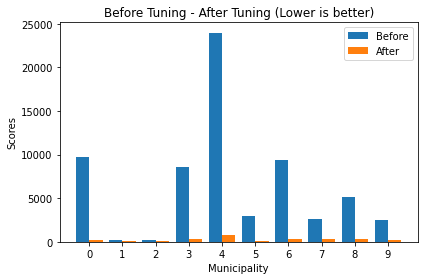

In [18]:
plot_scores(rmse_scores_tes, rmse_scores_tes_tuned)

## 2. SARIMA Hyperparameter Tuning

In here we will use another tuning approach rather than Optuna for SARIMA.

In [19]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

def sarima_optimizer(train, test, pdq, seasonal_pdq):
    best_rmse, best_mae,best_order, best_seasonal_order = float("inf"), float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(train_sets[train]["usage"], order=param, seasonal_order=param_seasonal).fit(disp=0)
                y_pred_test = model.get_forecast(steps=len(test_sets[test]))
                y_pred = y_pred_test.predicted_mean
                rmse = np.sqrt(mean_squared_error(test_sets[test]['usage'], y_pred))
                if rmse < best_rmse:
                    best_rmse, best_order, best_seasonal_order = rmse, param, param_seasonal
                    best_mae = mean_absolute_error(test, y_pred)
            except:
                continue

    print('Best score for {}. Municipality: SARIMA{}x{}7 - RMSE:{}'.format(tr[-1], best_order, best_seasonal_order, best_rmse))
    return best_order, best_seasonal_order, best_rmse, best_mae

In [20]:
rmse_scores_sar_tuned = []
model_sar_params = dict()

for tr, te in zip(train_sets.keys(), test_sets.keys()):
    best_order, best_seasonal_order, best_rmse, best_mae = sarima_optimizer(tr, te, pdq, seasonal_pdq)
    rmse_scores_sar_tuned.append(best_rmse)
    model_sar_params[f"model{tr[-1]}"] = best_order, best_seasonal_order

Best score for 0. Municipality: SARIMA(1, 1, 0)x(0, 1, 1, 7)7 - RMSE:267.72143014866515
Best score for 1. Municipality: SARIMA(1, 1, 1)x(0, 0, 1, 7)7 - RMSE:82.4973425937719
Best score for 2. Municipality: SARIMA(1, 1, 0)x(0, 0, 0, 7)7 - RMSE:120.89668265067668
Best score for 3. Municipality: SARIMA(0, 0, 0)x(0, 1, 1, 7)7 - RMSE:352.47290981854115
Best score for 4. Municipality: SARIMA(0, 0, 1)x(1, 0, 1, 7)7 - RMSE:796.7105014575494
Best score for 5. Municipality: SARIMA(1, 0, 1)x(1, 0, 1, 7)7 - RMSE:107.24699676460976
Best score for 6. Municipality: SARIMA(0, 1, 1)x(0, 1, 1, 7)7 - RMSE:287.7213292422515
Best score for 7. Municipality: SARIMA(0, 1, 0)x(1, 0, 1, 7)7 - RMSE:285.3424486094579
Best score for 8. Municipality: SARIMA(0, 0, 1)x(1, 1, 1, 7)7 - RMSE:274.8120712531801
Best score for 9. Municipality: SARIMA(1, 1, 1)x(0, 1, 1, 7)7 - RMSE:177.31754936758884


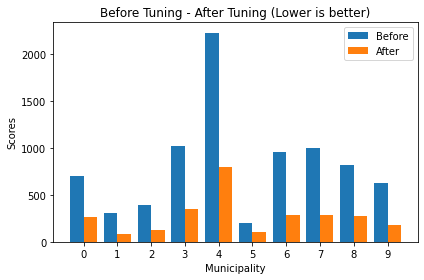

In [21]:
plot_scores(rmse_scores_sar, rmse_scores_sar_tuned)

## 3. LGBM Hyperparameter Tuning

In [22]:
params = dict(
    max_depth = hp.randint("max_depth", 2, 15),
    early_stopping_rounds = hp.randint("early_stopping_rounds", 2, 350),
    feature_fraction = hp.uniform("feature_fraction", 0.5, 1),
    learning_rate = hp.uniform("learning_rate", 0.0001, 0.2),
    num_boost_round= hp.randint("num_boost_round", 50, 2500),
    num_leaves = hp.randint("num_leaves", 10, 100),
    n_jobs = -1,
    random_state=41,
    verbosity=-9999)


def lgbm_objective(params, train, test):
    lgb_train = lgb.Dataset(train_sets[train].drop("date", axis=1), label=train_sets[train]["usage"])
    lgb_val = lgb.Dataset(test_sets[test].drop("date", axis=1), label=test_sets[test]["usage"])
    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_val],
                      num_boost_round=params['num_boost_round'],
                      early_stopping_rounds=params['early_stopping_rounds'],
                      verbose_eval=False)
    y_pred = model.predict(test_sets[test].drop("date", axis=1), num_iteration=model.best_iteration)
    rmse = np.sqrt(mean_squared_error(test_sets[test]['usage'], y_pred))
    return rmse

In [23]:
rmse_scores_lgbm_tuned = list()
model_lgbm_params = dict()
for tr, te in zip(train_sets.keys(), test_sets.keys()):
    print(f"Process started for {tr[-1]}. Municipality")
    trials = Trials()
    best = fmin(
    fn=lambda params: lgbm_objective(params, tr, te),
    space = params,
    algo=tpe.suggest,
    max_evals=200,
    trials=trials,
    verbose=False)

    best_rmse = trials.results[np.argmin([r['loss'] for r in trials.results])]['loss']
    print(f"Best RMSE score for {tr[-1]}. Municipality: {best_rmse}\nBest parameters for {tr[-1]}: {best}")
    # Best RMSE
    rmse_scores_lgbm_tuned.append(best_rmse)
    model_lgbm_params[f"model{tr[-1]}"] = best
    print("".center(50, "~"))

Process started for 0. Municipality
Best RMSE score for 0. Municipality: 23.93828497837109
Best parameters for 0: {'early_stopping_rounds': 189, 'feature_fraction': 0.991225338392763, 'learning_rate': 0.15270824838486827, 'max_depth': 8, 'num_boost_round': 1732, 'num_leaves': 68}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Process started for 1. Municipality
Best RMSE score for 1. Municipality: 0.8832838937927528
Best parameters for 1: {'early_stopping_rounds': 115, 'feature_fraction': 0.6743584700179759, 'learning_rate': 0.13979712155551735, 'max_depth': 12, 'num_boost_round': 1776, 'num_leaves': 28}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Process started for 2. Municipality
Best RMSE score for 2. Municipality: 3.960392693564198
Best parameters for 2: {'early_stopping_rounds': 98, 'feature_fraction': 0.8769540008156027, 'learning_rate': 0.04486135134647899, 'max_depth': 8, 'num_boost_round': 1906, 'num_leaves': 19}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
P

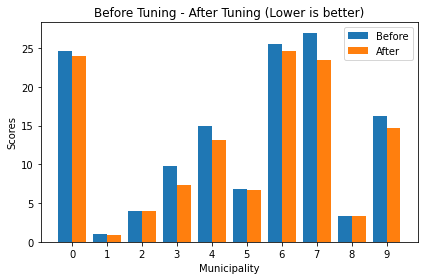

In [24]:
plot_scores(rmse_scores_lgb, rmse_scores_lgbm_tuned)

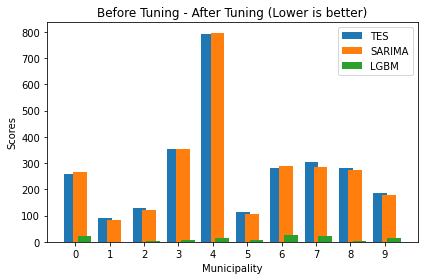

In [25]:
def plot_final_scores(tes, sar, lgbm):
    labels = range(10)
    x = np.arange(10)  # the label locations
    width = 0.4  # the width of the bars
    fig, ax = plt.subplots()
    ax.bar(x - width/3, tes, width, label='TES')
    ax.bar(x + width/3, sar, width, label='SARIMA')
    ax.bar(x + width*2/3, lgbm, width, label='LGBM')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_xlabel("Municipality")
    ax.set_title('Before Tuning - After Tuning (Lower is better)')
    ax.set_xticks(labels)
    ax.legend()
    fig.tight_layout()
    plt.show();

plot_final_scores(rmse_scores_tes_tuned, rmse_scores_sar_tuned, rmse_scores_lgbm_tuned)

As it can be seen, LGBM gave the best result. Therefore, the final model will be prepared with LGBM.
<br>

# Final Model

Firstly, check the last week and the first week of the test set errors.

In [26]:
def final_model(train, test, params):
    lgb_train = lgb.Dataset(train_sets[train].drop("date", axis=1), label=train_sets[train]["usage"])
    lgb_val = lgb.Dataset(test_sets[test].drop("date", axis=1), label=test_sets[test]["usage"])
    model = lgb.train(params, lgb_train,
                          valid_sets=[lgb_train, lgb_val],
                          num_boost_round=params['num_boost_round'],
                          early_stopping_rounds=params['early_stopping_rounds'],
                          verbose_eval=False)
    all_test = test_sets[test].drop("date", axis=1)
    first_week = all_test[:int(len(all_test)/2)]
    last_week = all_test[int(len(all_test)/2):]

    y_pred = model.predict(all_test, num_iteration=model.best_iteration)
    y_pred_first = model.predict(first_week, num_iteration=model.best_iteration)
    y_pred_last = model.predict(last_week, num_iteration=model.best_iteration)

    rmse_first = np.sqrt(mean_squared_error(test_sets[test]['usage'][:int(len(test_sets[test])/2)], y_pred_first))
    rmse_last = np.sqrt(mean_squared_error(test_sets[test]['usage'][int(len(test_sets[test])/2):], y_pred_last))
    print(f"First Week RMSE for {tr[-1]}. Municipality: {rmse_first}")
    print(f"Last Week RMSE for {tr[-1]}. Municipality:: {rmse_last}")
    return y_pred

First Week RMSE for 0. Municipality: 2.299220968224204
Last Week RMSE for 0. Municipality:: 33.77567998354277


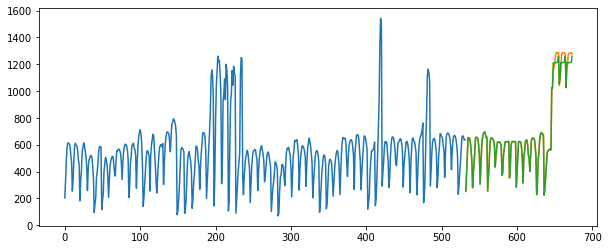

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
First Week RMSE for 1. Municipality: 1.0229296106523629
Last Week RMSE for 1. Municipality:: 0.7169350638084175


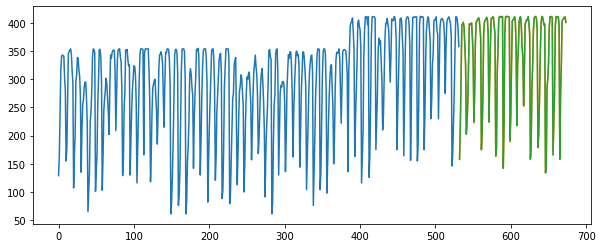

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
First Week RMSE for 2. Municipality: 3.6352225225274486
Last Week RMSE for 2. Municipality:: 4.260818910277994


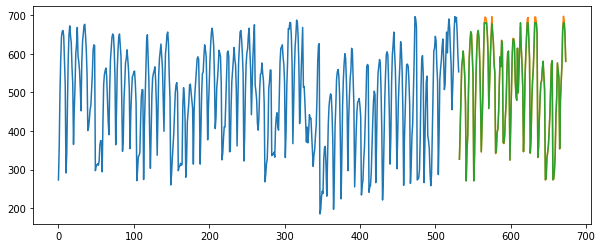

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
First Week RMSE for 3. Municipality: 7.18521814255018
Last Week RMSE for 3. Municipality:: 7.3558462082948495


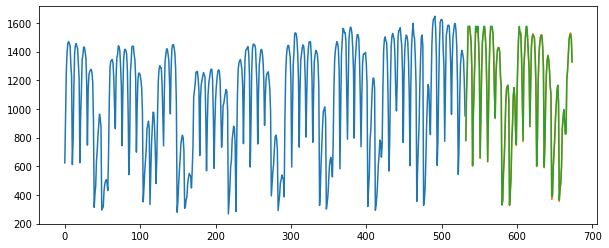

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
First Week RMSE for 4. Municipality: 12.311146765060952
Last Week RMSE for 4. Municipality:: 14.02425803491143


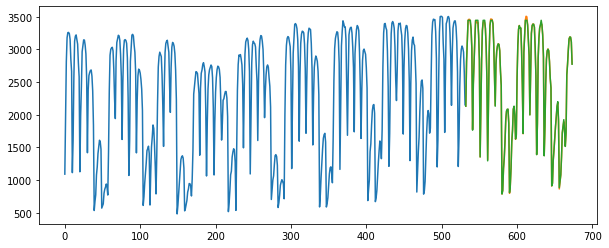

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
First Week RMSE for 5. Municipality: 7.855497552003566
Last Week RMSE for 5. Municipality:: 5.183760116726818


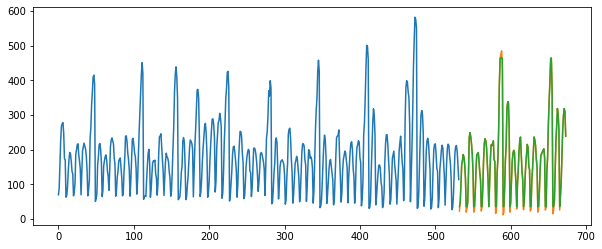

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
First Week RMSE for 6. Municipality: 3.361005733432607
Last Week RMSE for 6. Municipality:: 34.70175254704979


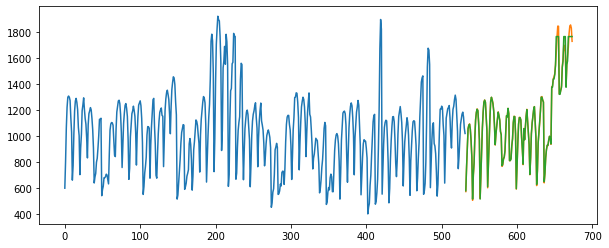

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
First Week RMSE for 7. Municipality: 21.289742234259304
Last Week RMSE for 7. Municipality:: 25.536242234790635


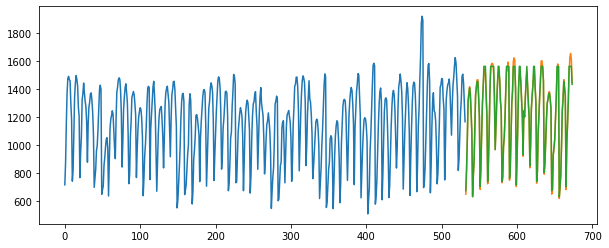

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
First Week RMSE for 8. Municipality: 3.7495370202217386
Last Week RMSE for 8. Municipality:: 2.7560718063763687


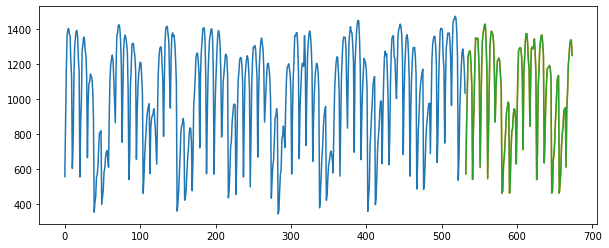

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
First Week RMSE for 9. Municipality: 15.909511534770061
Last Week RMSE for 9. Municipality:: 13.469698898374018


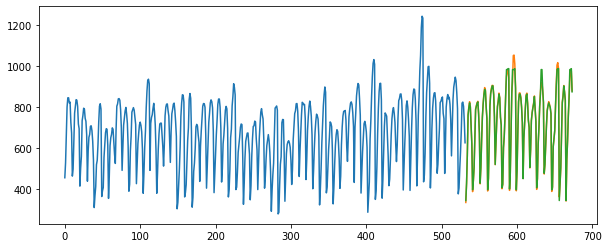

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [27]:
for tr, te in zip(train_sets.keys(), test_sets.keys()):
    params = model_lgbm_params[f"model{tr[-1]}"]
    params["verbosity"] = -999
    y_pred = final_model(tr, te, params)

    plot_tr = train_sets[tr]["usage"]
    plot_tr.index = range(0, len(plot_tr))

    plot_test = test_sets[te]["usage"]
    plot_test.index = range(len(plot_tr), len(plot_tr)+len(plot_test))

    y_pred = pd.DataFrame(y_pred)
    y_pred.index = range(len(plot_tr), len(plot_tr)+len(plot_test))
    plt.figure(figsize=(10, 4))
    plt.plot(plot_tr)
    plt.plot(plot_test)
    plt.plot(y_pred)
    plt.show();
    print("".center(50, "~"))

Especially for Municipality 0, RMSE scores are so different. The outliers can be observed on graph, as well. The outlier analysis and feature engineering can be done, and model can be improved on further steps. Also, hybrid model can be prepared, which includes TES, SARIMA and LGBM. The predictions coming from each model can be considered and the prediction can be done.